<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/microclimate_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
# install/upgrade the packages we need
!pip -q install pandas numpy requests "tensorflow==2.20.0" "keras==3.11.3" scikit-learn "keras-tuner==1.4.0" -U


In [103]:
# import all the packages that we need
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
from keras import layers
keras.utils.set_random_seed(42) # set seed to ensure reproducibility
from keras import ops
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable, Dict, Iterable, Union, Any
import time
import tensorflow as tf
import math
import pandas as pd
import requests
import json
from datetime import datetime,timedelta,timezone,date
from typing import Dict, Any,  Tuple
from sklearn.preprocessing import StandardScaler
from __future__ import annotations
import keras_tuner as kt
import shutil, os

In [104]:
def fetch_couva_weather_data(
    latitude: float = 10.44,
    longitude: float = -61.44,
    total_days: int = 365,
    safety_lag_days: int = 5
) -> pd.DataFrame:
    """
    Fetch hourly weather data for Couva, Trinidad from open-meteo.com.

    Args:
        latitude: Geographic latitude of Couva in decimal degrees.
        longitude: Geographic longitude of Couva in decimal degrees.
        total_days: Number of days of historical data to retrieve.
        safety_lag_days: Buffer days to ensure only finalized historical data.

    Returns:
        A DataFrame indexed by local datetime with columns:
        ['temperature', 'humidity', 'pressure', 'wind_speed', 'precipitation'].
    """
    end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)
    start_date: date = end_date - timedelta(days=total_days)

    api_base_url: str = "https://archive-api.open-meteo.com/v1/era5"
    query_parameters: Dict[str, Any] = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "hourly": ",".join([
            "temperature_2m",
            "relative_humidity_2m",
            "surface_pressure",
            "wind_speed_10m",
            "precipitation"
        ]),
        "timezone": "America/Port_of_Spain"
    }

    response = requests.get(api_base_url, params=query_parameters, timeout=60)
    response.raise_for_status()
    weather_json: Dict[str, Any] = response.json()

    datetimes_local = pd.to_datetime(weather_json["hourly"]["time"])
    weather_dataframe = pd.DataFrame({
        "temperature": weather_json["hourly"]["temperature_2m"],
        "humidity": weather_json["hourly"]["relative_humidity_2m"],
        "pressure": weather_json["hourly"]["surface_pressure"],
        "wind_speed": weather_json["hourly"]["wind_speed_10m"],
        "precipitation": weather_json["hourly"]["precipitation"],
    }, index=datetimes_local)

    # Ensure chronological order and fill tiny gaps
    weather_dataframe = weather_dataframe.sort_index().interpolate(limit_direction="both")

    return weather_dataframe

# Call the function to actually fetch the data
couva_weather_dataframe: pd.DataFrame = fetch_couva_weather_data()
# print a quick summary
print(couva_weather_dataframe.head(), couva_weather_dataframe.tail(), couva_weather_dataframe.shape)


/tmp/ipython-input-4277003254.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)


                     temperature  humidity  pressure  wind_speed  \
2024-10-18 00:00:00         26.4        83    1010.2         8.8   
2024-10-18 01:00:00         26.1        85    1009.4         7.2   
2024-10-18 02:00:00         25.9        85    1008.8         6.9   
2024-10-18 03:00:00         25.7        86    1008.4         6.9   
2024-10-18 04:00:00         25.6        86    1008.3         6.0   

                     precipitation  
2024-10-18 00:00:00            0.0  
2024-10-18 01:00:00            0.0  
2024-10-18 02:00:00            0.0  
2024-10-18 03:00:00            0.0  
2024-10-18 04:00:00            0.0                        temperature  humidity  pressure  wind_speed  \
2025-10-18 19:00:00         24.5        93    1010.4        12.3   
2025-10-18 20:00:00         25.1        89    1011.1         8.6   
2025-10-18 21:00:00         25.1        90    1011.9         8.7   
2025-10-18 22:00:00         25.3        90    1011.9         7.6   
2025-10-18 23:00:00         2

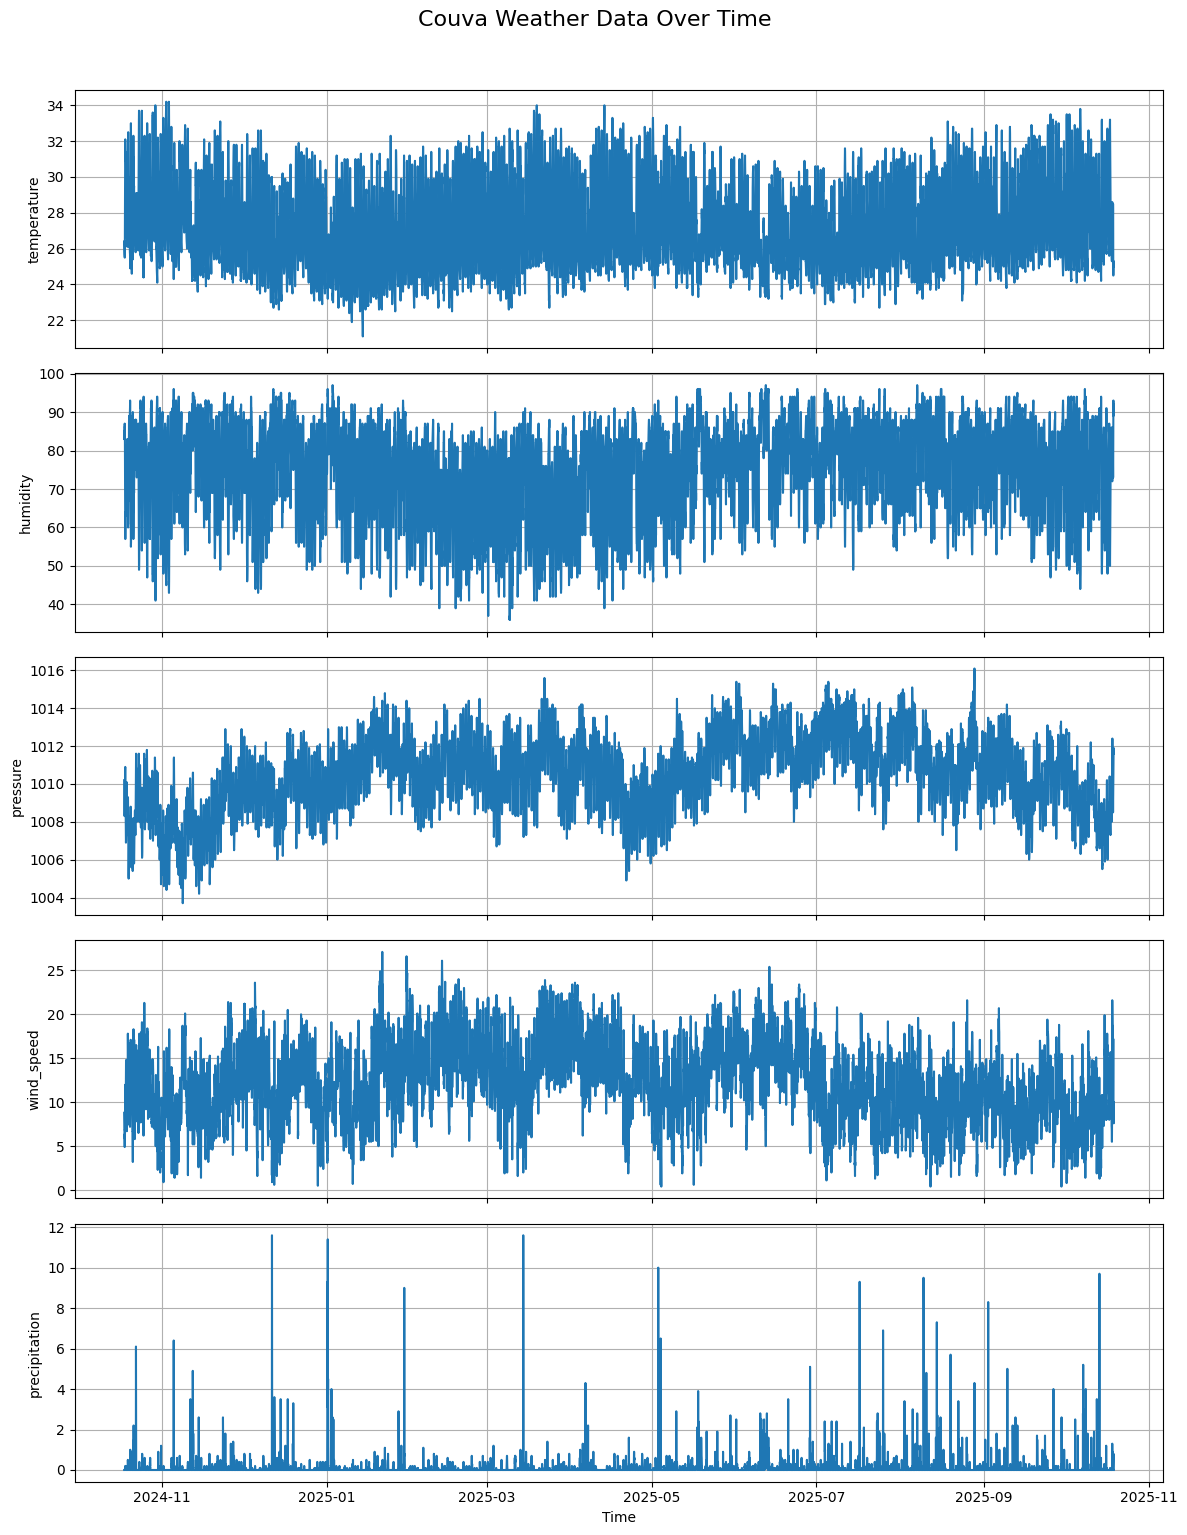

In [105]:
# Plot each weather feature over time so we can see what it looks like
fig, axes = plt.subplots(nrows=len(couva_weather_dataframe.columns), ncols=1, figsize=(12, 15), sharex=True)

for i, col in enumerate(couva_weather_dataframe.columns):
    axes[i].plot(couva_weather_dataframe.index, couva_weather_dataframe[col])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.xlabel("Time")
fig.suptitle("Couva Weather Data Over Time", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [106]:
# Add time-based features
couva_weather_dataframe['hour'] = couva_weather_dataframe.index.hour
couva_weather_dataframe['day_of_week'] = couva_weather_dataframe.index.dayofweek
couva_weather_dataframe['month'] = couva_weather_dataframe.index.month

# Display the updated dataframe with new features
print(couva_weather_dataframe.head())

                     temperature  humidity  pressure  wind_speed  \
2024-10-18 00:00:00         26.4        83    1010.2         8.8   
2024-10-18 01:00:00         26.1        85    1009.4         7.2   
2024-10-18 02:00:00         25.9        85    1008.8         6.9   
2024-10-18 03:00:00         25.7        86    1008.4         6.9   
2024-10-18 04:00:00         25.6        86    1008.3         6.0   

                     precipitation  hour  day_of_week  month  
2024-10-18 00:00:00            0.0     0            4     10  
2024-10-18 01:00:00            0.0     1            4     10  
2024-10-18 02:00:00            0.0     2            4     10  
2024-10-18 03:00:00            0.0     3            4     10  
2024-10-18 04:00:00            0.0     4            4     10  


In [107]:
def create_sliding_windows(
    feature_matrix: np.ndarray,
    target_array: np.ndarray,
    window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequential sliding windows for supervised learning on time-series data.

    Args:
        feature_matrix: 2-D NumPy array [num_samples, num_features]
                        containing the input features (already normalized).
        target_array:   1-D NumPy array [num_samples] containing target values
                        (for our case, next-hour temperature).
        window_size:    Number of time steps (hours) to include per input sample.

    Returns:
        Tuple of:
          X_windows: 3-D array [num_sequences, window_size, num_features]
          y_targets: 1-D array [num_sequences] matching each input window
    """

    sequential_features: list[np.ndarray] = []  # stores each sliding window of features
    sequential_targets: list[float] = []        # stores the target value for each window

    # iterate over all possible start indices that produce a full window
    for start_index in range(len(feature_matrix) - window_size + 1):
        end_index = start_index + window_size  # end of this window

        # slice the historical portion of the data (past `window_size` hours)
        current_window: np.ndarray = feature_matrix[start_index:end_index, :]
        sequential_features.append(current_window)

        # the label is the target value *at the end* of this window
        current_target: float = target_array[end_index - 1]
        sequential_targets.append(current_target)

    # convert lists to NumPy arrays for training
    return (
        np.array(sequential_features, dtype=np.float32),
        np.array(sequential_targets, dtype=np.float32)
    )


# ---------------------------------------------------------------------
# CONFIGURATION: define how far back we look and how far ahead we predict
# ---------------------------------------------------------------------

historical_window_hours: int = 168   # number of past hours to use as input
forecast_horizon_hours: int = 1     # predict the temperature 1 hour into the future


# ---------------------------------------------------------------------
# ALIGN FEATURES AND TARGETS
# ---------------------------------------------------------------------

# Shift the temperature column forward by `forecast_horizon_hours`
# so each row’s target corresponds to a future reading.
target_series: pd.Series = couva_weather_dataframe["temperature"].shift(-forecast_horizon_hours)

# Combine features and shifted target into a single aligned DataFrame,
# then drop any NaN values caused by the shift.
combined_dataframe: pd.DataFrame = pd.concat(
    [couva_weather_dataframe, target_series.rename("target_temperature")],
    axis=1
).dropna()


# ---------------------------------------------------------------------
# NORMALIZE (STANDARDIZE) FEATURES
# ---------------------------------------------------------------------

# ML models converge faster when our inputs have zero mean and unit variance.
# We fit the scaler on *all* features (not including the target/y) and transform them.
standard_scaler: StandardScaler = StandardScaler()
normalized_features: np.ndarray = standard_scaler.fit_transform(
    combined_dataframe.drop(columns=["target_temperature"])
)

# Extract target values as a NumPy array of float32 (to match TensorFlow’s dtype).
target_values: np.ndarray = combined_dataframe["target_temperature"].to_numpy(dtype=np.float32)


# ---------------------------------------------------------------------
# BUILD SUPERVISED LEARNING WINDOWS
# ---------------------------------------------------------------------

# Convert the continuous time series into overlapping sequences.
input_sequences, target_sequences = create_sliding_windows(
    feature_matrix=normalized_features,
    target_array=target_values,
    window_size=historical_window_hours
)


# ---------------------------------------------------------------------
# SPLIT DATASET CHRONOLOGICALLY
# ---------------------------------------------------------------------

# We never shuffle time-series data, because order matters.
# Instead, we split it into train/validation/test segments by time.
num_total_samples: int = len(input_sequences)
num_train_samples: int = int(0.70 * num_total_samples) # take 70% for training
num_validation_samples: int = int(0.85 * num_total_samples)  # then 15% for validation and the remaining 15 % for test

# Perform the splits
X_train: np.ndarray = input_sequences[:num_train_samples]
y_train: np.ndarray = target_sequences[:num_train_samples]

X_validate: np.ndarray = input_sequences[num_train_samples:num_validation_samples]
y_validate: np.ndarray = target_sequences[num_train_samples:num_validation_samples]

X_test: np.ndarray = input_sequences[num_validation_samples:]
y_test: np.ndarray = target_sequences[num_validation_samples:]

# Display shapes so we know exactly what each dataset looks like
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validate.shape, y_validate.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (6031, 168, 8) (6031,)
Validation set shape: (1292, 168, 8) (1292,)
Test set shape: (1293, 168, 8) (1293,)


##The image below illustrates how we're using the sliding-window forecasting to predict two example features (temperature and humidity)

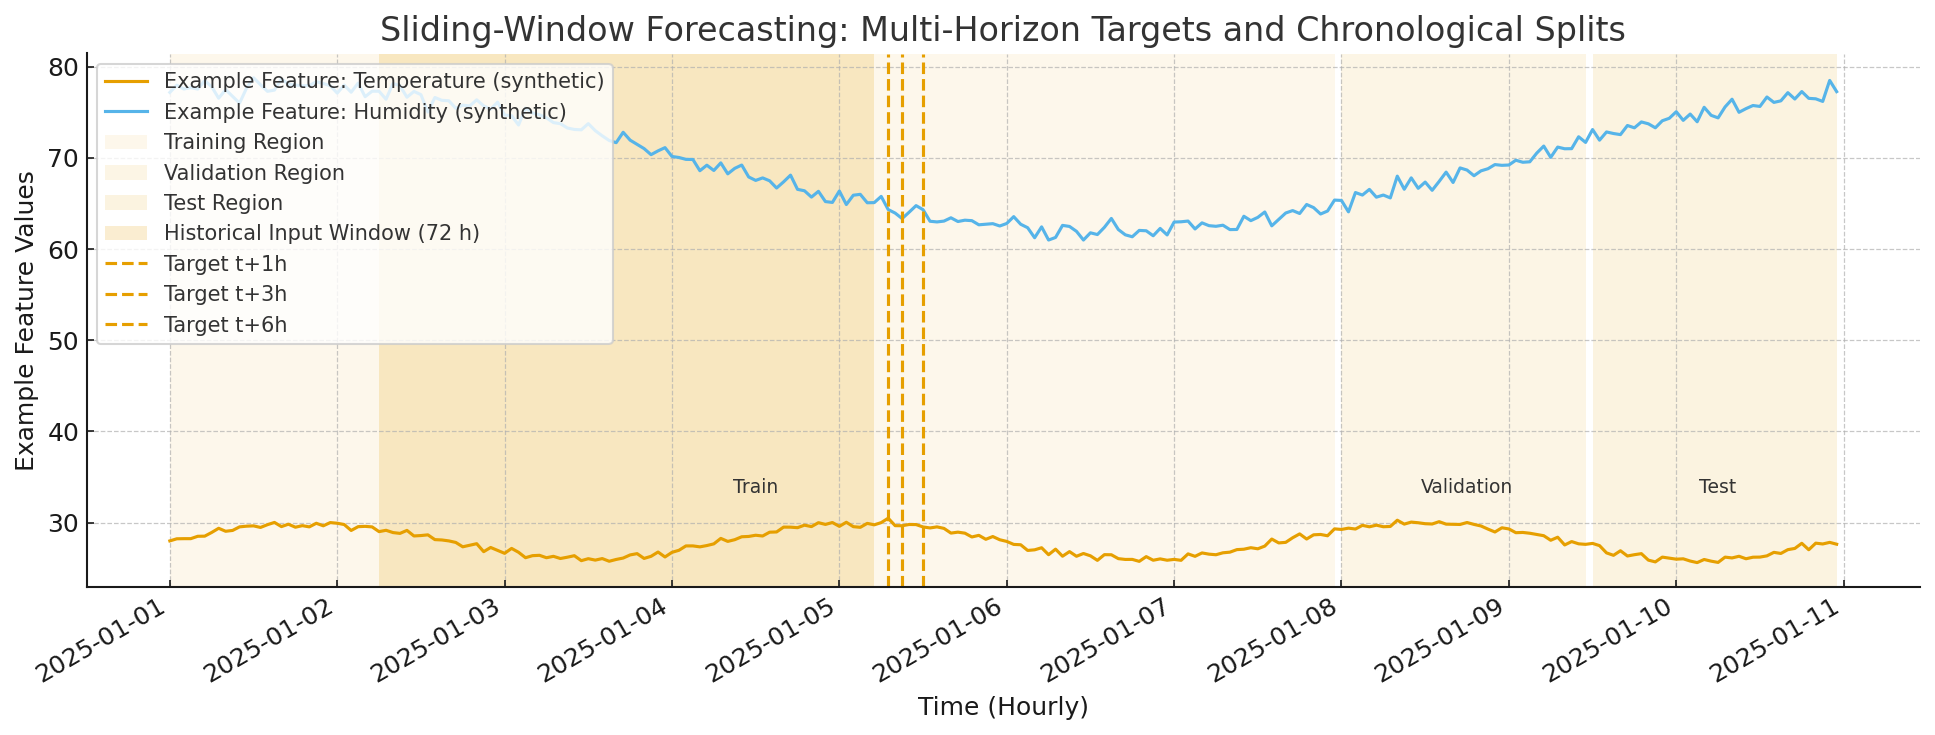

In [108]:
def build_one_dimensional_convolutional_model(
    input_window_length: int,
    number_of_input_features: int,
    dropout_rate: float = 0.10,
    first_block_filters: int = 16,
    second_block_filters: int = 32,
) -> keras.Model:
    """
    We want to build a tiny, clean 1D CNN that predicts next-hour temperature.
    We want something we can actually deploy on a microcontroller:
      - a small parameter count so it fits comfortably,
      - enough temporal receptive field to cover our 72-hour window,
      - layers that behave nicely after INT8 quantization

    Args:
        input_window_length: how many past hours each input sample contains (e.g., 72).
        number_of_input_features: feature count per hour (temp, humidity, pressure, wind, rain = 5).
        dropout_rate: gentle regularization to keep overfitting in check.
        first_block_filters: channels for the first convolutional block.
        second_block_filters: channels for the second (separable) block.

    Returns:
        A compiled Keras regression model that outputs one scalar temperature.
    """

    # Our inputs are [time_steps, features]. Batch dimension appears at runtime.
    input_layer: keras.layers.Input = keras.Input(
        shape=(input_window_length, number_of_input_features),
        name="input_window"
    )

    # ----- Convolutional Block 1 -----
    # First pass: capture short hourly trends with a slightly wider kernel (k=5).
    convolution_1: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=5,
        padding="same",
        activation="relu",
        name="conv1_k5_f16"
    )(input_layer)

    # Second pass: a tighter kernel (k=3) to refine features and add nonlinearity.
    convolution_2: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="conv2_k3_f16"
    )(convolution_1)

    # We downsample the time axis by 2 so the model stays lightweight.
    pooled_features_1: layers.Layer = layers.MaxPooling1D(
        pool_size=2,
        name="maxpool1_stride2"
    )(convolution_2)

    # ----- Convolutional Block 2 (separable = cheaper) -----
    # SeparableConv1D keeps accuracy decent while cutting parameters and MACs.
    separable_convolution: layers.Layer = layers.SeparableConv1D(
        filters=second_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="sepconv_k3_f32"
    )(pooled_features_1)

    # Instead of Flatten + Dense (parameter heavy), we average across time.
    global_temporal_aggregate: layers.Layer = layers.GlobalAveragePooling1D(
        name="global_average_pool"
    )(separable_convolution)

    # A touch of dropout for stability; small rate so we do not underfit.
    regularized_features: layers.Layer = layers.Dropout(
        rate=dropout_rate,
        name="dropout_regularization"
    )(global_temporal_aggregate)

    # Final linear head: give us one float, the next-hour temperature.
    output_temperature: layers.Layer = layers.Dense(
        units=1,
        dtype="float32",  # keep outputs in float32; avoids accidental dtype promotions downstream
        name="predicted_temperature"
    )(regularized_features)

    # Wire up the graph.
    model: keras.Model = keras.Model(
        inputs=input_layer,
        outputs=output_temperature,
        name="lightweight_1d_cnn_forecaster"
    )

    # Defaults that work: Adam + MSE for training, MAE for easy-to-read error in °C.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [109]:
input_window_length: int = X_train.shape[1]
number_of_input_features: int = X_train.shape[2]
weather_forecasting_model = build_one_dimensional_convolutional_model(
    input_window_length=input_window_length,
    number_of_input_features=number_of_input_features,
    dropout_rate=0.10,
    first_block_filters=16,second_block_filters=64
)
weather_forecasting_model.summary()

Model: "lightweight_1d_cnn_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_window (InputLayer)       │ (None, 168, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_k5_f16 (Conv1D)           │ (None, 168, 16)        │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_k3_f16 (Conv1D)           │ (None, 168, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_stride2 (MaxPooling1D) │ (None, 84, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sepconv_k3_f32                  │ (None, 84, 64)         │         1,136 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pool             │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_regularization          │ (None, 64)             │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predicted_temperature (Dense)   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,641 (10.32 KB)

 Trainable params: 2,641 (10.32 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
def build_model_for_tuning(hp, input_window_length: int, number_of_input_features: int):
    # Example: your existing build function, but pulling hyperparams from hp
    dropout_rate = hp.Float("dropout_rate", 0.0, 0.3, step=0.05, default=0.0)
    first_block_filters = hp.Choice("first_block_filters", [16, 32, 64], default=16)
    second_block_filters = hp.Choice("second_block_filters", [64, 128, 256], default=64)
    third_block_filters = hp.Choice("third_block_filters", [128, 256, 512], default=128)
    learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4], default=1e-2)

    model = build_one_dimensional_convolutional_model(
        input_window_length=input_window_length,
        number_of_input_features=number_of_input_features,
        dropout_rate=dropout_rate,
        first_block_filters=first_block_filters,
        second_block_filters=second_block_filters,
    )
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model

In [ ]:
shutil.rmtree("keras_tuner_dir/weather_forecaster_tuning", ignore_errors=True)

project_name: str = f"weather_forecaster_tuning_nfeat{X_train.shape[-1]}_win{X_train.shape[1]}"

tuner = kt.RandomSearch(
    hypermodel=lambda hp: build_model_for_tuning(hp, X_train.shape[1], X_train.shape[-1]),
    objective="val_mae",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner_dir",
    project_name=project_name,
)

tuner.search(X_train, y_train, validation_data=(X_validate, y_validate), epochs=40, batch_size=64)
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# Rebuild a *fresh* model from best HP (no old weights to clash)
best_model = build_model_for_tuning(best_hyperparameters, X_train.shape[1], X_train.shape[-1])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |0                 |dropout_rate
64                |64                |first_block_filters
256               |256               |second_block_filters
256               |256               |third_block_filters
0.0001            |0.0001            |learning_rate

Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 720.4240 - mae: 26.7179 - val_loss: 687.0046 - val_mae: 26.1103
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 539.3391 - mae: 22.9097 - val_loss: 343.5712 - val_mae: 18.3877
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 81.4577 - mae: 7.3623 - val_loss: 36.4210 - val_mae: 5.4553
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 14.3087 - mae: 3.1555 - val_loss: 23.9814 - val_mae: 4.1852
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 11.8522 - mae: 2.8715 - val_loss: 16.9047 - val_mae: 3.3500
Epoch 6/40
58/95 ━━━━━━━━━━━━━━━━━━━━ 